# Compare peak shapes and background scans at different positions


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from pathlib import Path
from lmfit.models import LinearModel, LorentzianModel, ConstantModel
import sys
sys.path.insert(1, '..')
from src import readfiles, wdscan

class Scan():

    def __init__(self, data, metadata):
        
        self.data = data
        self.metadata = metadata   

def plot_spectrum_and_roi(df, roi, sample=None, baseline=None):
    
    """ Plots 'regions of interest' (roi) defined for fitting background to spectrum """
    
    fig, ax = plt.subplots(figsize=(15,4))

    plt.plot(df['L'], df['cps_per_nA'], lw=1, color='k', label='data')
    
    if baseline is not None:
        plt.plot(df['L'], baseline, lw=1, color='b', label='baseline')
    
    for r in roi:
        ax.axvspan(r[0], r[1], alpha=0.1, color='red', linewidth=0)
        
    df_roi = select_roi(df, roi)
    
    ymin = df_roi['cps_per_nA'].min() - df_roi['cps_per_nA'].max()*0.05
    ymax = df_roi['cps_per_nA'].max() + df_roi['cps_per_nA'].max()*0.3
    
    plt.ylim(ymin, ymax)
    plt.title(sample)
    plt.tight_layout()
    
def select_roi(df, roi):
    
    """For a dataframe df, select rows within energy ranges defined by roi (regions of interest)"""
    
    idx_list = [df[(df.L > r[0]) & (df.L < r[1])].index.to_list() for r in roi]
    flat_idx_list = [item for sublist in idx_list for item in sublist]
    df_roi = df.loc[flat_idx_list, :]
    
    return df_roi


def fit_baseline_and_plot(df, roi, name=None, bg_type='linear'):
    
    """ Fit the baseline, store results as new columns in df, and plot the fit and roi."""
       
    bg_fit_result = fit_bg(select_roi(df, roi), bg_type=bg_type)
    
    baseline = bg_fit_result.eval(x=df['L'].values)
    
    corrected_data = df['cps_per_nA'].values - baseline

    plot_spectrum_and_roi(df, roi, sample=name, baseline=baseline)

    df['baseline'] = baseline
    df['cps_per_nA_corrected'] = corrected_data
    
def fit_bg(data, bg_type='linear'):
    
    """ bg_type can be either:
            - 'linear' (default)
            - 'lorentzian_plus_c' 
    """

    x = data.L
    y = data.cps_per_nA

    if bg_type == 'linear':
        
        mod = LinearModel()
        pars = mod.make_params(slope=0, intercept=-1)
        
    elif bg_type == 'lorentzian_plus_c':
        
        mod = LorentzianModel() + ConstantModel()
        pars = mod.make_params(amplitude=max(y)*10, sigma=10, center=120, c=0)
        
        pars['amplitude'].set(min=0)
        pars['center'].set(max=130)        
        pars['c'].set(max=min(y))
    
    bg_fit_result = mod.fit(y, pars, x=x)
    
    return bg_fit_result

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from pathlib import Path
from lmfit.models import LinearModel, LorentzianModel, ConstantModel
import sys
sys.path.insert(1, '..')
from src import readfiles, wdscan

class Scan():

    def __init__(self, data, metadata):
        
        self.data = data
        self.metadata = metadata   

def plot_spectrum_and_roi(df, roi, sample=None, baseline=None):
    
    """ Plots 'regions of interest' (roi) defined for fitting background to spectrum """
    
    fig, ax = plt.subplots(figsize=(15,4))

    plt.plot(df['L'], df['cps_per_nA'], lw=1, color='k', label='data')
    
    if baseline is not None:
        plt.plot(df['L'], baseline, lw=1, color='b', label='baseline')
    
    for r in roi:
        ax.axvspan(r[0], r[1], alpha=0.1, color='red', linewidth=0)
        
    df_roi = select_roi(df, roi)
    
    ymin = df_roi['cps_per_nA'].min() - df_roi['cps_per_nA'].max()*0.05
    ymax = df_roi['cps_per_nA'].max() + df_roi['cps_per_nA'].max()*0.3
    
    plt.ylim(ymin, ymax)
    plt.title(sample)
    plt.tight_layout()
    
def select_roi(df, roi):
    
    """For a dataframe df, select rows within energy ranges defined by roi (regions of interest)"""
    
    idx_list = [df[(df.L > r[0]) & (df.L < r[1])].index.to_list() for r in roi]
    flat_idx_list = [item for sublist in idx_list for item in sublist]
    df_roi = df.loc[flat_idx_list, :]
    
    return df_roi


def fit_baseline_and_plot(df, roi, name=None, bg_type='linear'):
    
    """ Fit the baseline, store results as new columns in df, and plot the fit and roi."""
       
    bg_fit_result = fit_bg(select_roi(df, roi), bg_type=bg_type)
    
    baseline = bg_fit_result.eval(x=df['L'].values)
    
    corrected_data = df['cps_per_nA'].values - baseline

    plot_spectrum_and_roi(df, roi, sample=name, baseline=baseline)

    df['baseline'] = baseline
    df['cps_per_nA_corrected'] = corrected_data
    
def fit_bg(data, bg_type='linear'):
    
    """ bg_type can be either:
            - 'linear' (default)
            - 'lorentzian_plus_c' 
    """

    x = data.L
    y = data.cps_per_nA

    if bg_type == 'linear':
        
        mod = LinearModel()
        pars = mod.make_params(slope=0, intercept=-1)
        
    elif bg_type == 'lorentzian_plus_c':
        
        mod = LorentzianModel() + ConstantModel()
        pars = mod.make_params(amplitude=max(y)*10, sigma=10, center=120, c=0)
        
        pars['amplitude'].set(min=0)
        pars['center'].set(max=130)        
        pars['c'].set(max=min(y))
    
    bg_fit_result = mod.fit(y, pars, x=x)
    
    return bg_fit_result

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import glob
import sys
sys.path.insert(1, '..')
from src import readfiles, helper_funs
from pathlib import Path

# **Warning:**
# Files named 001 and 002 do not always correspond to the same crystal! So this information must be extracted from the metadata.
# So get all the data into one big list!

allfolders = sorted(glob.glob('../data/raw/wavelength_scans/*/*'))

data_list = []
metadata_list = []

for i in range(len(allfolders)):
    _, data, metadata = readfiles.import_jeol_wdscans(allfolders[i],
                                                         'data001_mm.csv', 'data001.cnd',
                                                         comment_line_num=80,
                                                         return_metadata=True)
    data_list.append(data)
    metadata_list.append(metadata)
    
    _, data, metadata = readfiles.import_jeol_wdscans(allfolders[i],
                                                         'data002_mm.csv', 'data002.cnd',
                                                         comment_line_num=80,
                                                         return_metadata=True)
    data_list.append(data)
    metadata_list.append(metadata)
    
# Then split the data based on crystal

scans = {'LDE1L': {}, 'LDE1': {}}

for i, m in enumerate(metadata_list):
    if m.crystal == 'LDE1L':
        scans['LDE1L'][m.folder.parts[4]] = Scan(data_list[i], m)
    elif m.crystal == 'LDE1':
        scans['LDE1'][m.folder.parts[4]] = Scan(data_list[i], m)
    

In [4]:
pd.concat(metadata_list, axis=1)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
folder,..\data\raw\wavelength_scans\A870_50nA\Pos_0002,..\data\raw\wavelength_scans\A870_50nA\Pos_0002,..\data\raw\wavelength_scans\A876_50nA\Pos_0003,..\data\raw\wavelength_scans\A876_50nA\Pos_0003,..\data\raw\wavelength_scans\B989_50nA\Pos_0001,..\data\raw\wavelength_scans\B989_50nA\Pos_0001,..\data\raw\wavelength_scans\B994_50nA\Pos_0004,..\data\raw\wavelength_scans\B994_50nA\Pos_0004,..\data\raw\wavelength_scans\aln_long_100nA\Po...,..\data\raw\wavelength_scans\aln_long_100nA\Po...,...,..\data\raw\wavelength_scans\gan_short_50nA_2\...,..\data\raw\wavelength_scans\gan_short_50nA_2\...,..\data\raw\wavelength_scans\gan_short_50nA_3\...,..\data\raw\wavelength_scans\gan_short_50nA_3\...,..\data\raw\wavelength_scans\hyalophane_150nA\...,..\data\raw\wavelength_scans\hyalophane_150nA\...,..\data\raw\wavelength_scans\hyalophane_60nA\P...,..\data\raw\wavelength_scans\hyalophane_60nA\P...,..\data\raw\wavelength_scans\si3n4_long_100nA\...,..\data\raw\wavelength_scans\si3n4_long_100nA\...
comment,A870_20um_50nA,A870_20um_50nA,A876_20um_50nA,A876_20um_50nA,B989_20um_50nA,B989_20um_50nA,B994_20um_50nA,B994_20um_50nA,AlN_long,AlN_long,...,GaN_short_20um_50nA_5,GaN_short_20um_50nA_5,GaN_short_20um_50nA_6,GaN_short_20um_50nA_6,hyalophane_10um_150nA,hyalophane_10um_150nA,hyalophane_20um_60nA,hyalophane_20um_60nA,Si3N4_long,Si3N4_long
current_nA,50.09,50.09,50.08,50.08,50.13,50.13,50.1,50.1,99.32,99.32,...,50.04,50.04,50.03,50.03,151.0,151.0,59.91,59.91,99.88,99.88
dwell_time_s,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.6,0.6,...,0.6,0.6,0.6,0.6,1.0,1.0,1.0,1.0,0.6,0.6
accumulations,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
num_points,1501,1501,1501,1501,1501,1501,1501,1501,2001,2001,...,309,309,309,309,1501,1501,1501,1501,2001,2001
total_time_mins,25,25,25,25,25,25,25,25,20,20,...,3,3,3,3,25,25,25,25,20,20
crystal,LDE1L,LDE1,LDE1L,LDE1,LDE1L,LDE1,LDE1L,LDE1,LDE1,LDE1L,...,LDE1L,LDE1,LDE1L,LDE1,LDE1L,LDE1,LDE1L,LDE1,LDE1,LDE1L
step_size_um,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,20.0,20.0,...,130.0,130.0,130.0,130.0,40.0,40.0,40.0,40.0,20.0,20.0


In [5]:
[k for k, _ in scans['LDE1L'].items()]

['A870_50nA',
 'A876_50nA',
 'B989_50nA',
 'B994_50nA',
 'aln_long_100nA',
 'bn_long_100nA',
 'bn_short_100nA_1',
 'bn_short_100nA_2',
 'bn_short_100nA_3',
 'bn_short_100nA_4',
 'bn_short_50nA_1',
 'bn_short_50nA_2',
 'bn_short_50nA_3',
 'bn_short_50nA_4',
 'bn_short_50nA_5',
 'bn_short_50nA_6',
 'bn_short_50nA_7',
 'gan_long_100nA',
 'gan_short_100nA_1',
 'gan_short_100nA_2',
 'gan_short_100nA_3',
 'gan_short_50nA_1',
 'gan_short_50nA_2',
 'gan_short_50nA_3',
 'hyalophane_150nA',
 'hyalophane_60nA',
 'si3n4_long_100nA']

In [6]:
[k for k, _ in scans['LDE1'].items()]

['A870_50nA',
 'A876_50nA',
 'B989_50nA',
 'B994_50nA',
 'aln_long_100nA',
 'bn_long_100nA',
 'bn_short_100nA_1',
 'bn_short_100nA_2',
 'bn_short_100nA_3',
 'bn_short_100nA_4',
 'bn_short_50nA_1',
 'bn_short_50nA_2',
 'bn_short_50nA_3',
 'bn_short_50nA_4',
 'bn_short_50nA_5',
 'bn_short_50nA_6',
 'bn_short_50nA_7',
 'gan_long_100nA',
 'gan_short_100nA_1',
 'gan_short_100nA_2',
 'gan_short_100nA_3',
 'gan_short_50nA_1',
 'gan_short_50nA_2',
 'gan_short_50nA_3',
 'hyalophane_150nA',
 'hyalophane_60nA',
 'si3n4_long_100nA']

In [7]:
scans['LDE1L']['si3n4_long_100nA'].metadata

folder             ..\data\raw\wavelength_scans\si3n4_long_100nA\...
comment                                                   Si3N4_long
current_nA                                                     99.88
dwell_time_s                                                     0.6
accumulations                                                      1
num_points                                                      2001
total_time_mins                                                   20
crystal                                                        LDE1L
step_size_um                                                    20.0
dtype: object

In [8]:
scans['LDE1L']['si3n4_long_100nA'].metadata

folder             ..\data\raw\wavelength_scans\si3n4_long_100nA\...
comment                                                   Si3N4_long
current_nA                                                     99.88
dwell_time_s                                                     0.6
accumulations                                                      1
num_points                                                      2001
total_time_mins                                                   20
crystal                                                        LDE1L
step_size_um                                                    20.0
dtype: object

In [9]:
scans['LDE1L']['si3n4_long_100nA'].data

,L,counts,cps,cps_per_nA
0,125.00,73.0,121.666667,1.218128
1,125.02,83.0,138.333333,1.384995
2,125.04,84.0,140.000000,1.401682
3,125.06,90.0,150.000000,1.501802
4,125.08,87.0,145.000000,1.451742
...,...,...,...,...
1996,164.92,19.0,31.666667,0.317047
1997,164.94,15.0,25.000000,0.250300
1998,164.96,19.0,31.666667,0.317047
1999,164.98,10.0,16.666667,0.166867


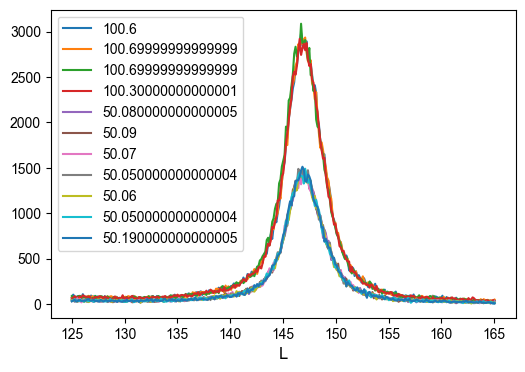

In [10]:
xtl = 'LDE1L'

fig, ax = plt.subplots()
for i in range(4):
    nm = f'bn_short_100nA_{i+1}'
    scans[xtl][nm].data.plot(x='L', y='cps', ax=ax, label=scans[xtl][nm].metadata.current_nA)

for i in range(7):
    nm = f'bn_short_50nA_{i+1}'
    scans[xtl][nm].data.plot(x='L', y='cps', ax=ax, label=scans[xtl][nm].metadata.current_nA)

Average data collected at same conditions

In [11]:
def average_scan(scans, group_name, xtl, n_repeats):
    
    df = pd.DataFrame(
        {'L': scans[xtl][f'{group_name}_1'].data.L
      , 'cps_per_nA': pd.concat([scans[xtl][f'{group_name}_{i+1}'].data['cps_per_nA'] 
                                 for i in range(n_repeats)]
                                , axis=1)
                      .mean(axis=1)
      , 'cps_per_nA_stdev': pd.concat([scans[xtl][f'{group_name}_{i+1}'].data['cps_per_nA'] 
                                       for i in range(n_repeats)]
                                    , axis=1)
                            .std(axis=1)
        })
    
    avg_metadata = (pd.concat([scans[xtl][f'{group_name}_{i+1}'].metadata 
                              for i in range(n_repeats)], axis=1)
                    .drop(index=['folder', 'comment', 'crystal'])
                    .mean(axis=1)
                   )
    avg_metadata['n'] = n_repeats
    
    avg_scan = Scan(data=df, metadata=avg_metadata)
    
    return avg_scan

In [12]:
avg_scans = {'LDE1': {}, 'LDE1L': {}}

for xtl in ['LDE1', 'LDE1L']:
    avg_scans[xtl]['bn_short_100nA'] = average_scan(scans, 'bn_short_100nA', xtl, 4)
    avg_scans[xtl]['bn_short_50nA'] = average_scan(scans, 'bn_short_50nA', xtl, 7)
    avg_scans[xtl]['bn_long_100nA'] = scans[xtl]['bn_long_100nA']
    avg_scans[xtl]['bn_long_100nA'].metadata['n'] = 1
    
    avg_scans[xtl]['gan_short_100nA'] = average_scan(scans, 'gan_short_100nA', xtl, 3)
    avg_scans[xtl]['gan_short_50nA'] = average_scan(scans, 'gan_short_50nA', xtl, 3)
    avg_scans[xtl]['gan_long_100nA'] = scans[xtl]['gan_long_100nA']
    avg_scans[xtl]['gan_long_100nA'].metadata['n'] = 1


In [ ]:
plt.rcParams['font.family'] = 'arial'

fig, ax = plt.subplots(2, 1, figsize=(8*0.39,14*0.39), sharex=True)

clrs = ['lightgrey', 'tab:orange', 'tab:blue']

for i, s in enumerate(['bn_long_100nA', 'bn_short_100nA', 'bn_short_50nA']):
    scan = avg_scans['LDE1L'][s]
    
    scan.data.plot(
        x='L', y='cps_per_nA', ax=ax[0], lw=1, color=clrs[i],
        label = '{:.0f} x {:.0f} min\n{} nA'.format(
        scan.metadata.n, scan.metadata.total_time_mins, s.split('_')[-1].replace('nA', '')))

for i, s in enumerate(['gan_long_100nA', 'gan_short_100nA', 'gan_short_50nA']):
    scan = avg_scans['LDE1L'][s]
    
    scan.data.plot(
        x='L', y='cps_per_nA', ax=ax[1], lw=1, color=clrs[i],
        label = '{:.0f} x {:.0f} min\n{} nA'.format(
        scan.metadata.n, scan.metadata.total_time_mins, s.split('_')[-1].replace('nA', '')))

ax[0].set_title('BN')
ax[1].set_title('GaN')

alphalabel = 'AB'
for i, a in enumerate(ax):
    a.set_xlabel('L (mm)', fontsize = 12)
    a.set_ylabel('cps/nA', fontsize = 12)
    a.set_xticks(np.arange(130, 170, 10))
    
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    a.text(0.93, 0.99, alphalabel[i], transform=a.transAxes + trans,
            fontsize=12, va='top', ha='right', fontfamily='Arial',
            bbox=dict(facecolor='w', edgecolor='grey', pad=3.0))
    
ax[0].legend(ncol=1, loc='upper left', bbox_to_anchor=(0,1), fontsize=9, frameon=False)
ax[1].legend(ncol=1, loc='upper left', bbox_to_anchor=(0,1), fontsize=9, frameon=False)

plt.tight_layout()

plt.savefig('../figures/nitride_peaks_at_different_conditions.pdf')

## Figure showing background of hyalophane is independent of beam current

In [13]:
hyal_60 = scans["LDE1L"]["hyalophane_60nA"]
hyal_150 = scans["LDE1L"]["hyalophane_150nA"]

Figure not saved


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Hyalophane'}, xlabel='L (mm)', ylabel='cps_per_nA'>)

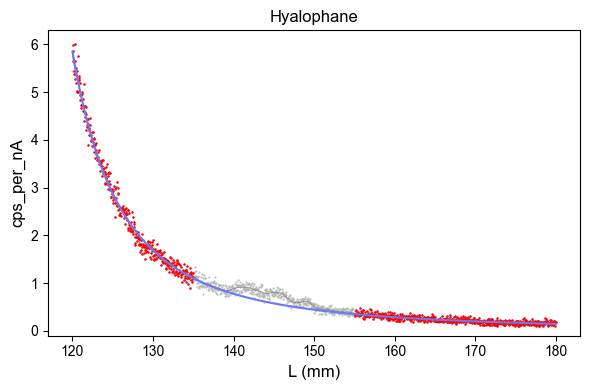

In [14]:
trimmed_data = wdscan.trim_data_from_regions(hyal_150.data, fit_regions=[[120,135], [155,180]])
out = wdscan.fit_bg(trimmed_data, cps_per_nA=True)
wdscan.plot_bg_fit(hyal_150.data, trimmed_data=trimmed_data, out=out, comment="Hyalophane", save_to=None, cps_per_nA=True, print_parameters=False)

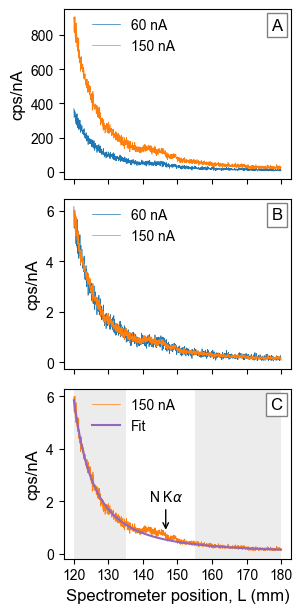

In [17]:
fig, ax = plt.subplot_mosaic(
    '''
    A
    B
    C
    ''',
    sharex=True,
    figsize=(8*0.39, 16*0.39)
     )

plt.sca(ax["A"])
hyal_60.data.plot(x='L', y='cps', ax=ax["A"], label='60 nA', lw=0.5, color="tab:blue")
hyal_150.data.plot(x='L', y='cps', ax=ax["A"], label='150 nA', lw=0.5, color="tab:orange")
plt.xlabel('L (mm)', fontsize=12)
plt.ylabel('cps', fontsize=12)

plt.sca(ax["B"])
hyal_60.data.plot(x='L', y='cps_per_nA', ax=ax["B"], label='60 nA', lw=0.5, color="tab:blue")
hyal_150.data.plot(x='L', y='cps_per_nA', ax=ax["B"], label='150 nA', lw=0.5, color="tab:orange")
plt.xlabel('L (mm)', fontsize=12)
plt.ylabel('cps/nA', fontsize=12)

plt.sca(ax["C"])
hyal_150.data.plot(x='L', y='cps_per_nA', ax=ax["C"], label='150 nA', lw=0.5, color="tab:orange")
fitted = out.eval(x=hyal_150.data.L)
plt.plot(hyal_150.data.L, fitted, '-', label="Fit", color='tab:purple', linewidth=1.5)
plt.axvspan(120, 135, facecolor="grey", alpha=0.15, edgecolor=None)
plt.axvspan(155, 180, facecolor="grey", alpha=0.15, edgecolor=None)

plt.annotate(
    text=r"N K$\alpha$",
    xy=(146.6, 0.8),
    xytext=(146.6, 2),
    ha="center",
    arrowprops={"arrowstyle": "->"}
)

for k, v in ax.items():
    v.set_xlabel('L (mm)', fontsize = 12)
    v.set_ylabel('cps/nA', fontsize = 12)
    v.set_xticks(np.arange(120, 190, 10))
    
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    v.text(0.93, 0.99, k, transform=v.transAxes + trans,
            fontsize=12, va='top', ha='right', fontfamily='Arial',
            bbox=dict(facecolor='w', edgecolor='grey', pad=3.0))

plt.xlabel('Spectrometer position, L (mm)', fontsize=12)
plt.ylabel('cps/nA', fontsize=12)

ax["A"].legend(framealpha=0, loc='upper left', bbox_to_anchor=(0.1, 0.98), borderaxespad=0)
ax["B"].legend(framealpha=0, loc='upper left', bbox_to_anchor=(0.1, 0.98), borderaxespad=0)
ax["C"].legend(framealpha=0, loc='upper left', bbox_to_anchor=(0.1, 0.98), borderaxespad=0)

plt.tight_layout()
plt.savefig('../figures/hyalophane_bg_at_different_currents.png')

In [ ]:
out